# Path Visualization and Optimization for AWS DeepRacer

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

from os import listdir
from os.path import isfile, join

%matplotlib inline

## Load waypoints for the track you want to run analysis on

In [4]:
print([f for f in listdir("tracks/") if isfile(join("tracks/", f))])

['Oval_track.npy', 'ChampionshipCup2019_track.npy', 'New_York_Track.npy', 'Mexico_track.npy', 'Tokyo_Training_track.npy', 'reinvent_base.npy', 'H_track.npy', 'Bowtie_track.npy', 'reInvent2019_track.npy', 'China_track.npy', 'Canada_Training.npy', 'reInvent2019_wide.npy', 'AWS_track.npy', 'London_Loop_Train.npy', 'reInvent2019_wide_mirrored.npy', 'Virtual_May19_Train_track.npy', 'Straight_track.npy', 'Vegas_track.npy']


In [5]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)

current_track = "reinvent_base"

track_waypoints = get_track_waypoints(current_track) ### re:invent track
track_waypoints.shape

(71, 6)

In [6]:
def wrap_360(theta):
    theta = theta % 360;
    theta = (theta + 360) % 360
    
    return theta

def wrap_180(theta):
    theta = wrap_360(theta)
    if theta > 180:
        theta -= 360

    return theta

def convert_slope(m):
    radians = math.atan2(m[1], m[0])
    dir1 = radians
    dir2 = (radians + np.pi) % (2 * np.pi)
    
    return [dir1, dir2]

def get_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def get_angle(l1, l2):
    d1x = l1[1][0] - l1[0][0]
    d1y = l1[1][1] - l1[0][1]
    d2x = l2[1][0] - l2[0][0]
    d2y = l2[1][1] - l2[0][1]
    
    return math.atan2(d1x * d2y - d1y * d2x, d1x * d2x + d1y * d2y)

def get_spline(points, centerpoint):
    x = points[:,0]
    y = points[:,1]

    x_min = min(x)    
    x = x - x_min
    
    theta = get_periodic(list(zip(x, y)), centerpoint)
    theta[0] = 0
    
    return CubicSpline(theta, points, bc_type='periodic')

def get_points(cs, num=250):
    xs = 2 * np.pi * np.linspace(0, 1, num)
    return cs(xs)

def get_periodic(points, centerpoint):
    value = []
    l1 = (centerpoint, (centerpoint[0]+1, centerpoint[1]))
    
    for point in points:
        l2 = (centerpoint, point)
        value.append(get_angle(l1, l2) + np.pi)
        
    return value

# def get_nearest_point(spline, point):
#     def f(x):
#         value = spline(x)[0]
#         return get_distance(value, point)

#     return minimize(f, [np.pi], method='L-BFGS-B', bounds=[(0, 2*np.pi)]).x[0]

# def get_best_position(way, position):
#     point = get_nearest_point(way, position)
    
#     position = way(point)
#     slope = way.derivative()(point)
    
#     return (position, slope)

def get_nearest_point(waypoints, point):
    min_i = None
    min_distance = math.inf

    for i, waypoint in enumerate(waypoints):
        distance = get_distance(waypoint, point)
        if distance < min_distance:
            min_i = i
            min_distance = distance
    
    return min_i

def get_best_position(waypoints, point):
    i1 = get_nearest_point(waypoints, point)
    p1 = waypoints[i1]
    
    i2 = i1 + 1
    if i2 > len(waypoints)-1:
        i2 = 0

    p2 = waypoints[i2]
    
    m = [p2[0] - p1[0], p2[1] - p1[1]]
    
    return p1, m

def plot_way(ax, cs, style="path"):
    xs = 2 * np.pi * np.linspace(0, 1, 250)
    cs_xs = cs(xs)
    x = cs_xs[:, 0]
    y = cs_xs[:, 1]
    
    if style == "path":
        ax.plot(x, y, label='spline')
    
    if style == "points":
        ax.scatter(x, y, s=20, label='spline')
    
def plot_slope(ax, point, slope, color="black"):
    x = point[0]
    y = point[1]
    
    rads = convert_slope(slope)[0]
    cos = np.cos(rads)
    
    slope = slope[1]/slope[0]
    
    b = y - (slope * x)
    xs = np.array([x-cos*.75, x+cos*.75])
    ys = (slope * xs) + b
    
    ax.plot(xs, ys, color=color)
    
def plot_best_position(ax, current_position, best_position, slope):
    positions = np.array([current_position, position])
    plot_waypoints(ax, positions, s=80, color="black")
    plot_slope(ax, position, slope)
    ax.plot(positions[:,0], positions[:,1], linestyle='dashed')

def plot_waypoints(ax, points, s=20, color=None, alpha=1):
    x = points[:,0]
    y = points[:,1]
    ax.scatter(x, y, s=s, color=color, alpha=alpha)

def plot_track_waypoints(ax, points):
    x = points[:,0]
    y = points[:,1]
    ax.plot(x, y, linewidth=5, alpha=.25)
    
def plot_track(ax, track_waypoints):
    plot_track_waypoints(ax, track_waypoints[:,0:2])
    plot_track_waypoints(ax, track_waypoints[:,2:4])
    plot_track_waypoints(ax, track_waypoints[:,4:6])

## Visualize the Track, Control Points and Way

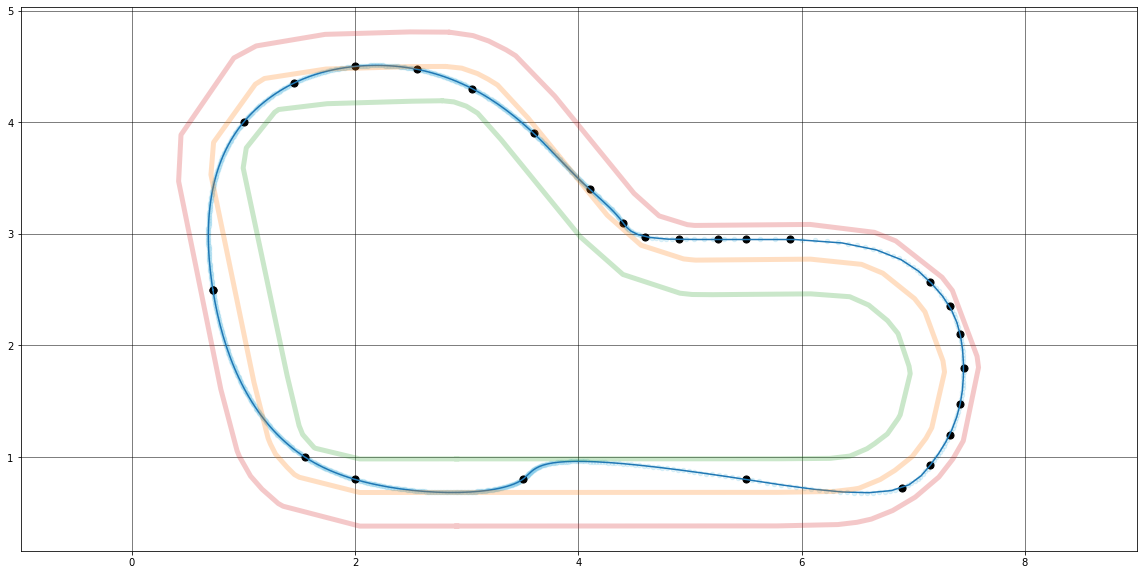

In [27]:
# Choose control points to draw the spline for the chosen optimal path
control_points = {
    "reinvent_base": np.array([
        [.725, 2.5], # should be same as starting waypoint
        [1.55, 1],
        [2, .8],
        [3.5, .8],
        [5.5, .8],
        [6.9, .725],
        [7.15, .925],
        [7.325, 1.2],
        [7.42, 1.475],
        [7.45, 1.8],
        [7.42, 2.1],
        [7.325, 2.35],
        [7.15, 2.57],
        [5.9, 2.95],
        [5.5, 2.95],
        [5.25, 2.95],
        [4.9, 2.95],
        [4.6, 2.975],
        [4.4, 3.1],
        [4.1, 3.4],
        [3.6, 3.9],
        [3.05, 4.3],
        [2.55, 4.475],
        [2, 4.5],
        [1.45, 4.35],
        [1, 4],
        [.725, 2.5] # should be same as first element in the list
    ])
}

current_control_points = control_points[current_track]

way = get_spline(current_control_points, centerpoint=(2, 2.5))
waypoints = get_points(way, 1000)

# Plot the results
fig, ax = plt.subplots(figsize=(20,10))
ax.axis('equal')

plot_way(ax, way)
plot_track(ax, track_waypoints)

plot_waypoints(ax, waypoints, alpha=.25, color="skyblue")
plot_waypoints(ax, current_control_points, s=50, color="black")

plt.grid(color='black', linestyle='-', linewidth=.5)
plt.show()

## Visualize Nearest Point

[-0.016558197915277795, 0.015173607141485856]


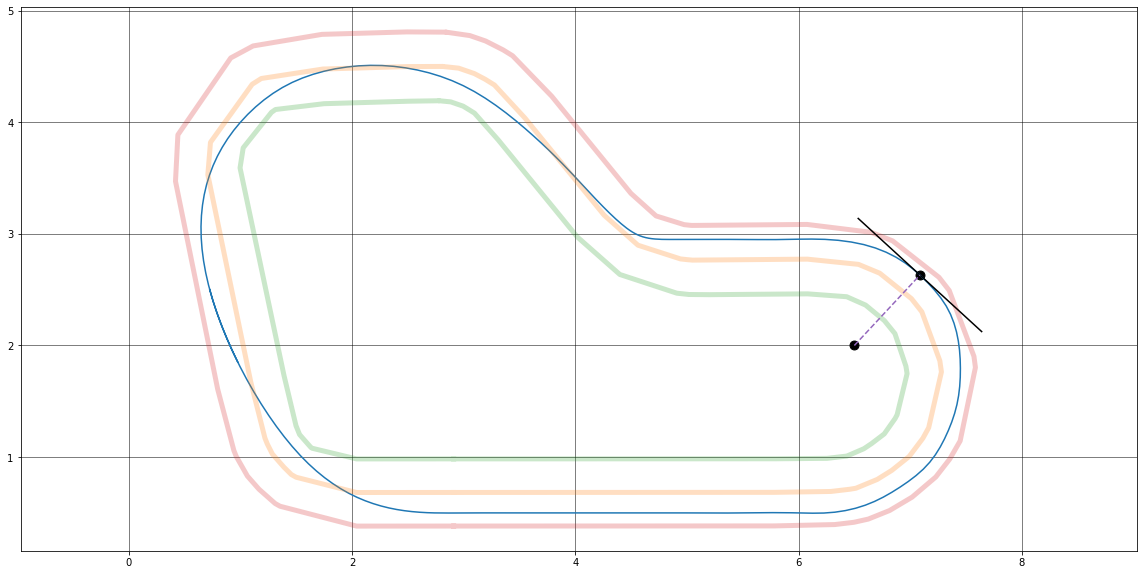

In [10]:
current_position = [6.5, 2]

position, slope = get_best_position(waypoints, current_position)

print(slope)

fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('equal')

plot_way(ax, way)
plot_track(ax, track_waypoints)

plot_best_position(ax, current_position, position, slope)

plt.grid(color='black', linestyle='-', linewidth=.5)

plt.show()

## Visualize Headings

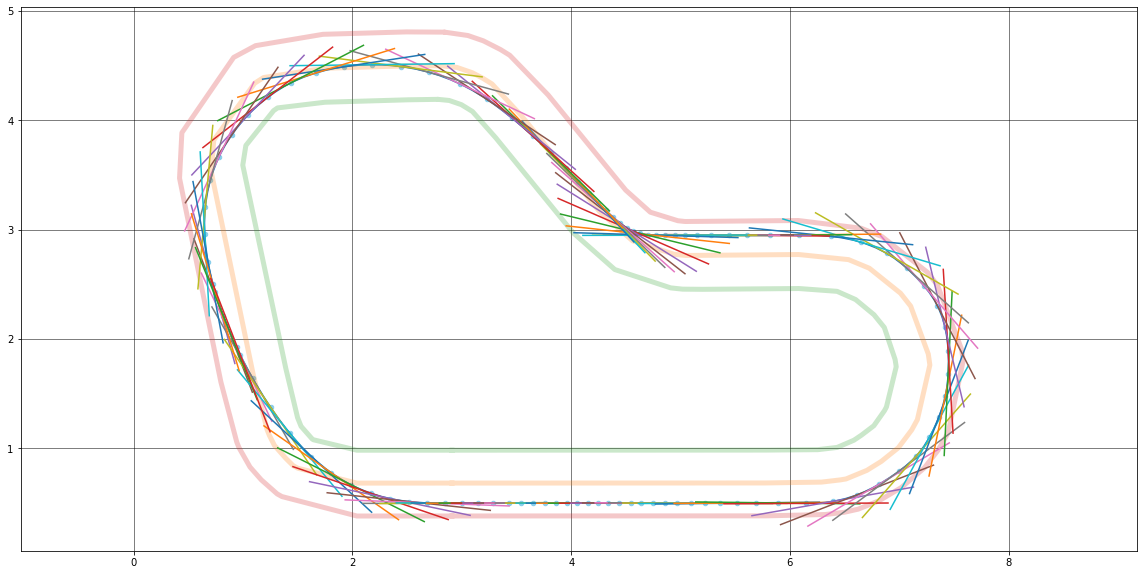

In [11]:
positions = way(2 * np.pi * np.linspace(0, 1, 100))

fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('equal')

plot_way(ax, way)
plot_track(ax, track_waypoints)

for position in positions:
    position, slope = get_best_position(waypoints, position)
    plot_slope(ax, position, slope, color=None)
    plot_waypoints(ax, np.array([position]), color="skyblue")

plt.grid(color='black', linestyle='-', linewidth=.5)

plt.show()

## Visualize Reward Function

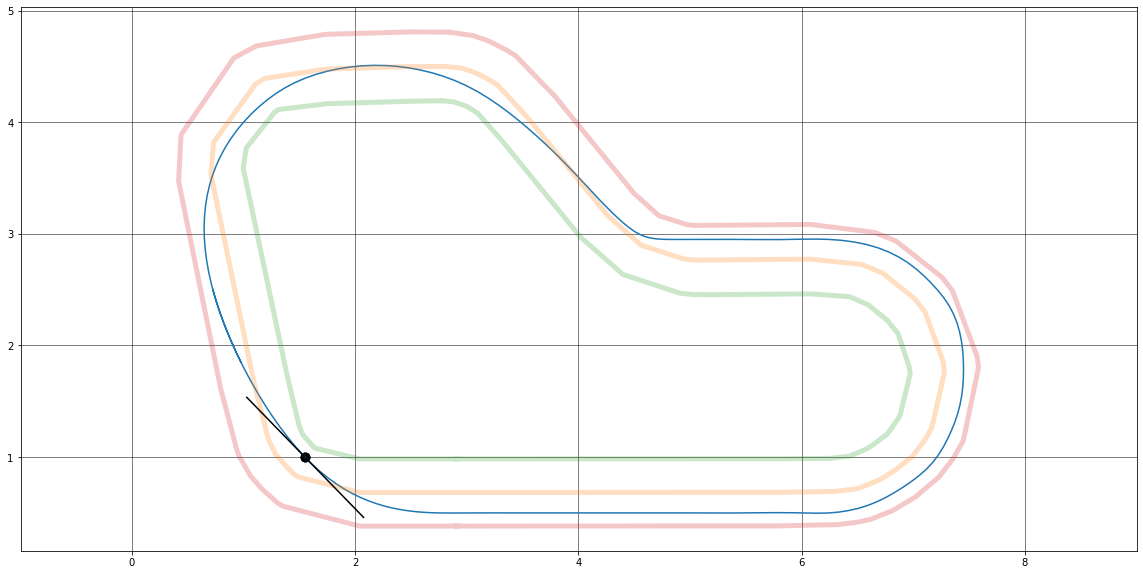

Params: {'all_wheels_on_track': True, 'track_width': 0.4, 'is_reversed': False, 'distance_from_center': 0.045, 'heading': 2.342459769108359, 'x': 1.55, 'y': 1}
Heading: 2.342459769108359
Best Position: [1.55216945 0.99773811]
Best Headings: [314.21305844909693, 134.21305844909693]
Difference from Best Position: 0.003134117845863528
Difference from Best Heading: 131.87059867998857
Position Reward: 3.9874733922940435
Heading Reward: 2.668952104143789
Reward: 113.26015629535732


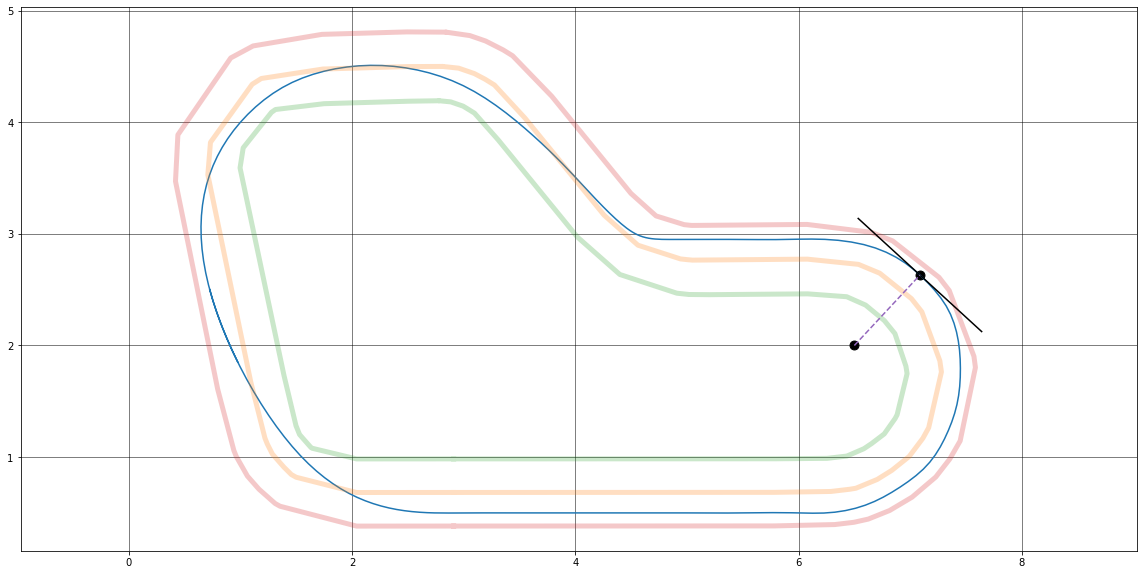

Params: {'all_wheels_on_track': True, 'track_width': 0.4, 'is_reversed': False, 'distance_from_center': 0.045, 'heading': 5.541393646713516, 'x': 6.5, 'y': 2}
Heading: 5.541393646713516
Best Position: [7.08752362 2.63126564]
Best Headings: [137.49846857729386, 317.4984685772938]
Difference from Best Position: 0.8623690147505577
Difference from Best Heading: 131.95707493058035
Position Reward: 1.6965681540187707
Heading Reward: 2.6681672972546226
Reward: 20.491263363184782


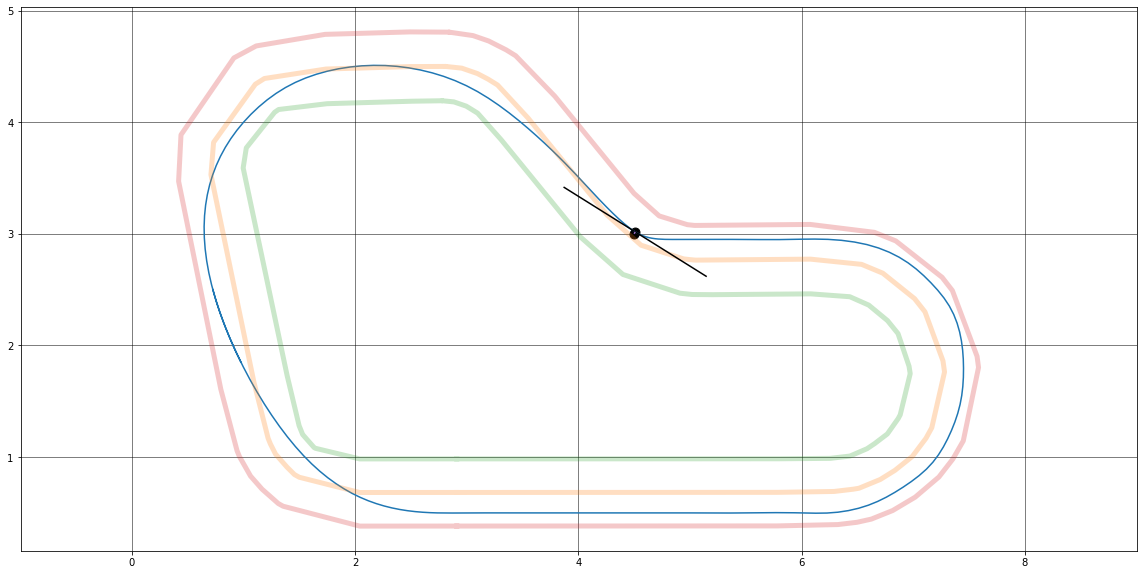

Params: {'all_wheels_on_track': True, 'track_width': 0.4, 'is_reversed': False, 'distance_from_center': 0.045, 'heading': 30, 'x': 4.5, 'y': 3}
Heading: 30
Best Position: [4.50821206 3.01822218]
Best Headings: [147.95685721317102, 327.95685721317113]
Difference from Best Position: 0.019987137426822843
Difference from Best Heading: 117.95685721317102
Position Reward: 3.920461473985649
Heading Reward: 2.7967279766716215
Reward: 120.21947707368302


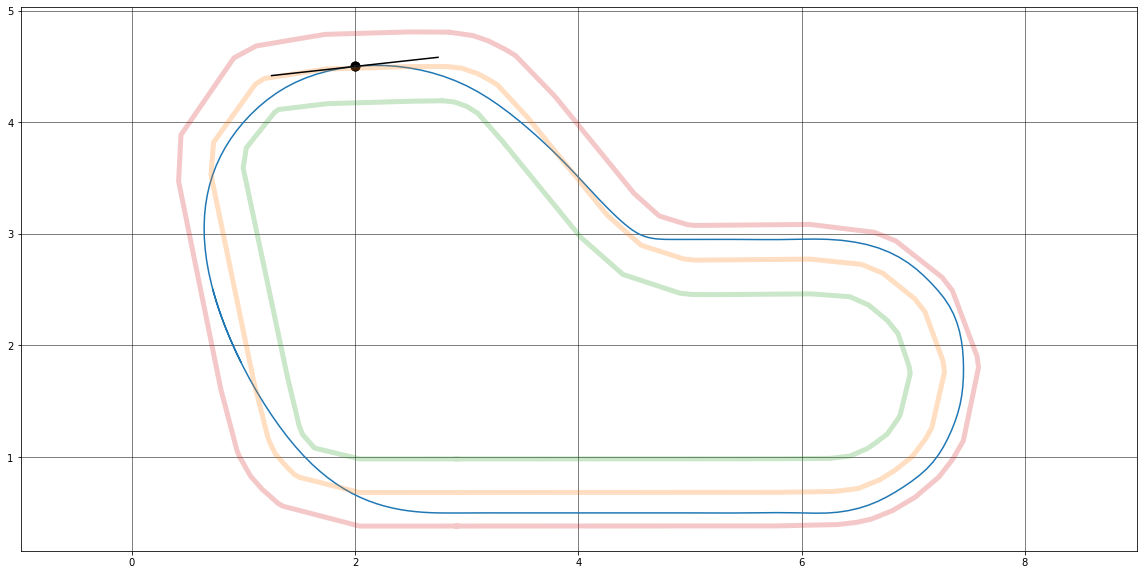

Params: {'all_wheels_on_track': True, 'track_width': 0.4, 'is_reversed': False, 'distance_from_center': 0.045, 'heading': -140, 'x': 2, 'y': 4.5}
Heading: 220
Best Position: [1.99693277 4.49968692]
Best Headings: [186.27168275759425, 6.271682757594249]
Difference from Best Position: 0.003083163421058476
Difference from Best Heading: 33.72831724240575
Position Reward: 3.987676891229701
Heading Reward: 3.6340186925535494
Reward: 209.99755433813345


209.99755433813345

In [13]:
def get_test_params(position, heading):
    return {
        # known good values
        'all_wheels_on_track': True,
        'track_width': .4,
        'is_reversed': False,
        'distance_from_center': .045,

        'heading': heading,
        'x': position[0],
        'y': position[1]
    }

def reward_function(params):
    # Read input parameters
    print('Params:', params)
    
    is_reversed = params['is_reversed']
    all_wheels_on_track = params['all_wheels_on_track']
    track_width = params['track_width']
    distance_from_center = params['distance_from_center']
    heading = params['heading']
    x = params['x']
    y = params['y']

    heading = wrap_360(heading)
    
    print("Heading:", heading)
    
    position = [x, y]
    
    # Give a very low reward by default
    reward = 1e-3

    best_position, slope = get_best_position(waypoints, [x, y])
    best_headings = [wrap_360(math.degrees(direction)) for direction in convert_slope(slope)]

    print("Best Position:", best_position)
    print("Best Headings:", best_headings)
    
    best_position_diff = get_distance(position, best_position)
    best_heading_diff = min([abs(heading - best_heading) for best_heading in best_headings])
    
    print("Difference from Best Position:", best_position_diff)
    print("Difference from Best Heading:", best_heading_diff)

    # Give a high reward if no wheels go off the track and
    # the agent is somewhere in between the track borders
    if not is_reversed and all_wheels_on_track and (0.5*track_width - distance_from_center) >= 0.05:
        reward = 1.0

    position_reward = (1 + (1 - math.tanh(best_position_diff))) ** 2
    heading_reward = (1 + (1 - best_heading_diff / 360)) ** 2
    reward *= (position_reward * heading_reward) ** 2
    
    print("Position Reward:", position_reward)
    print("Heading Reward:", heading_reward)    
    print("Reward:", reward)

    # Always return a float value
    return float(reward)


####################################### position 1 #######################################

current_position = [1.55, 1]
position, slope = get_best_position(waypoints, current_position)

fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('equal')

plot_way(ax, way)
plot_track(ax, track_waypoints)
plot_best_position(ax, current_position, position, slope)

plt.grid(color='black', linestyle='-', linewidth=.5)
plt.show()

reward_function(get_test_params(current_position, wrap_180(convert_slope(slope)[1])))


####################################### position 2 #######################################

current_position = [6.5, 2]
position, slope = get_best_position(waypoints, current_position)

fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('equal')

plot_way(ax, way)
plot_track(ax, track_waypoints)
plot_best_position(ax, current_position, position, slope)

plt.grid(color='black', linestyle='-', linewidth=.5)
plt.show()

reward_function(get_test_params(current_position, wrap_180(convert_slope(slope)[1])))


####################################### position 3 #######################################

current_position = [4.5, 3]
position, slope = get_best_position(waypoints, current_position)

fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('equal')

plot_way(ax, way)
plot_track(ax, track_waypoints)
plot_best_position(ax, current_position, position, slope)

plt.grid(color='black', linestyle='-', linewidth=.5)
plt.show()

reward_function(get_test_params(current_position, 30))


####################################### position 4 #######################################

current_position = [2, 4.5]
position, slope = get_best_position(waypoints, current_position)

fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('equal')

plot_way(ax, way)
plot_track(ax, track_waypoints)
plot_best_position(ax, current_position, position, slope)

plt.grid(color='black', linestyle='-', linewidth=.5)
plt.show()

reward_function(get_test_params(current_position, -140))